In [1]:
!pip install optuna
!pip install mlflow
!pip install xgboost
!pip install statsmodels --quiet
!pip install statsmodels tqdm

🚀 STARTING PIPELINE: HYBRID ARIMA + LGBM + BUFFER V3

📂 Loading data from CaRDS.csv...
   🔧 Cleaning Demand outliers...

🔨 Creating features...

📊 Splitting Data...

🔹 Step 1: Training ARIMA Anchor (Per Station)
⚠️  Warning: This process is slower than Ridge (approx 5-10 mins).


Fitting ARIMA: 100%|██████████| 404/404 [00:18<00:00, 21.97it/s]


   Mapping ARIMA predictions back...
📈 Anchor (ARIMA) Val R²: 0.8971

🔹 Step 2 & 3: Neutral LightGBM on Residuals...
🔹 Step 4: Applying Smart Floor...
🔹 Step 5: Applying Buffer V3 (Volatility Floor Strategy)...

FINAL EVALUATION

📊 VALIDATION SET:
   R²: 0.7571 | MAE: 45,771,973 | RMSE: 124,964,297
   ⚠️ Under-pred: 1.5% | Avg Shortage: 214,833
   ✅ Avg Surplus: 45,557,141 (Target)
   🌞 Summer Under-pred: 0.2%

📊 TEST SET:
   R²: 0.8752 | MAE: 52,871,745 | RMSE: 152,392,950
   ⚠️ Under-pred: 1.6% | Avg Shortage: 1,111,684
   ✅ Avg Surplus: 51,760,061 (Target)
   🌞 Summer Under-pred: 0.5%

📊 Generating Visualization...


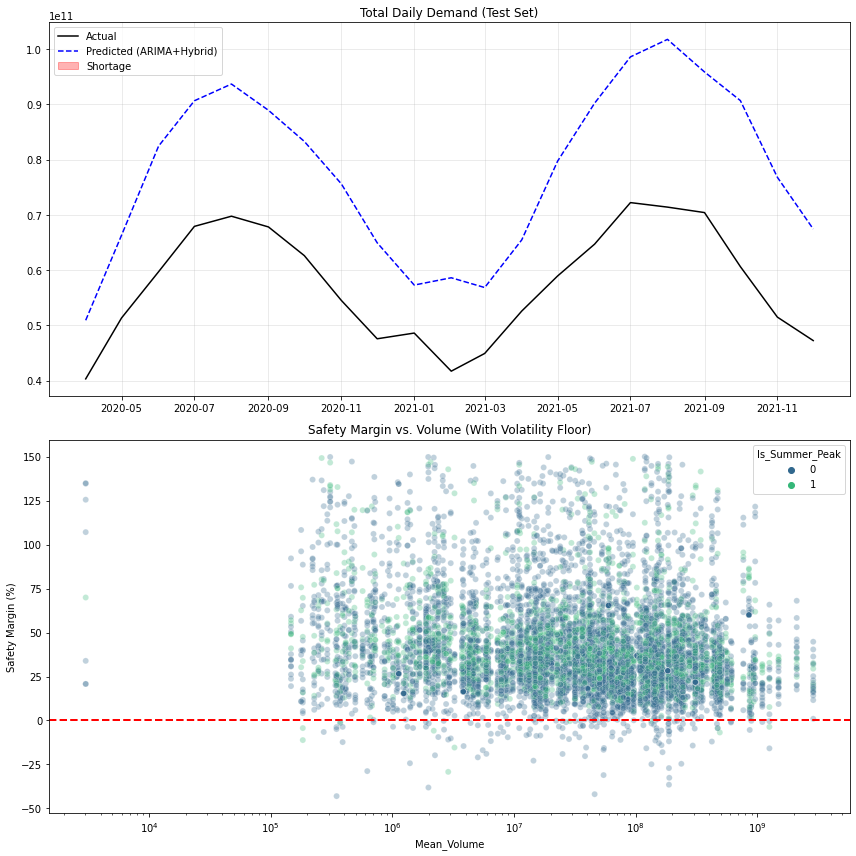


✅ PROCESS COMPLETE.


In [3]:
# =============================================================================
# FINAL HYBRID MODEL: ARIMA ANCHOR + NEUTRAL LGBM + VOLATILITY FLOOR (V3)
# Strategy: 
# 1. Anchor: ARIMA (Captures per-station seasonality & autocorrelation)
# 2. Residuals: LightGBM (Captures weather & complex interactions)
# 3. Buffer: Volatility Floor V3 (Balances PWSID 90 risk & PWSID 390 waste)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm # Thanh tiến trình
import warnings

# Cấu hình hiển thị
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
np.random.seed(42)

# === CONFIGURATION ===
FILE_PATH = "CaRDS.csv"
TEST_SIZE = 0.2
VAL_SIZE = 0.15

print("="*80)
print("🚀 STARTING PIPELINE: HYBRID ARIMA + LGBM + BUFFER V3")
print("="*80)

# =============================================================================
# 1. DATA LOADING & PROCESSING
# =============================================================================
def clean_physics_based(series):
    """Loại bỏ outlier vô lý"""
    median_val = series.median()
    if pd.isna(median_val) or median_val <= 0:
        return series.fillna(0)
    phys_min = median_val * 0.05
    phys_max = median_val * 10.0
    mask_invalid = (series < phys_min) | (series > phys_max)
    if mask_invalid.any():
        series_clean = series.copy()
        series_clean[mask_invalid] = np.nan
        series_clean = series_clean.interpolate(method='linear', limit_direction='both')
        return series_clean
    return series

def load_and_process_data(file_path):
    print(f"\n📂 Loading data from {file_path}...")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print("❌ Error: File not found. Please check FILE_PATH.")
        return None

    df['Variable'] = df['Variable'].astype(str).str.strip().str.lower()
    date_cols = [c for c in df.columns if c not in ['PWSID', 'Variable']]
    
    df_melt = df.melt(id_vars=['PWSID', 'Variable'], value_vars=date_cols,
                      var_name='Date', value_name='Value')
    df_pivot = df_melt.pivot_table(index=['PWSID', 'Date'],
                                   columns='Variable', values='Value').reset_index()
    
    rename_map = {'demand': 'Demand', 'temperature': 'Temperature',
                  'precipitation': 'Precipitation', 'pdsi': 'PDSI'}
    df_pivot.rename(columns=rename_map, inplace=True)
    df_pivot['Date'] = pd.to_datetime(df_pivot['Date'])
    df_final = df_pivot.sort_values(['PWSID', 'Date']).reset_index(drop=True)
    
    for col in ['Temperature', 'Precipitation', 'PDSI']:
        if col in df_final.columns:
            val = 0 if col == 'Precipitation' else df_final[col].median()
            df_final[col] = df_final[col].fillna(val)
    
    if 'Demand' in df_final.columns:
        print("   🔧 Cleaning Demand outliers...")
        df_final['Demand'] = df_final.groupby('PWSID')['Demand'].transform(clean_physics_based)
        df_final['Demand'] = df_final['Demand'].fillna(0)
        
    return df_final

# =============================================================================
# 2. FEATURE ENGINEERING
# =============================================================================
def create_features(df):
    print("\n🔨 Creating features...")
    df = df.copy()
    
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Is_Summer_Peak'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)
    
    # Weather Features for LightGBM
    if 'Temperature' in df.columns:
        df['CDD'] = np.maximum(df['Temperature'] - 18, 0)
        df['Temp_lag_1'] = df.groupby('PWSID')['Temperature'].shift(1)
        df['Summer_Heat_Interaction'] = df['Is_Summer_Peak'] * df['CDD']
    
    if 'Precipitation' in df.columns:
        df['Precip_lag_1'] = df.groupby('PWSID')['Precipitation'].shift(1)
    
    # Lags for LightGBM & Floor
    df['lag_1'] = df.groupby('PWSID')['Demand'].shift(1)
    df['lag_12'] = df.groupby('PWSID')['Demand'].shift(12)
    df['rolling_mean_12'] = df.groupby('PWSID')['Demand'].transform(
        lambda x: x.rolling(window=12, min_periods=1).mean())
    df['diff_12'] = df.groupby('PWSID')['Demand'].diff(12)
    
    df = df.fillna(method='bfill').fillna(0)
    return df

# LOAD
df = load_and_process_data(FILE_PATH)
if df is None: exit()
df_features = create_features(df)

# =============================================================================
# 3. SPLITTING
# =============================================================================
print("\n📊 Splitting Data...")
unique_dates = df_features['Date'].sort_values().unique()
n_test = int(len(unique_dates) * TEST_SIZE)
n_val = int(len(unique_dates) * VAL_SIZE)

test_start = unique_dates[-n_test]
val_start = unique_dates[-(n_test + n_val)]

train_df = df_features[df_features['Date'] < val_start].copy()
val_df = df_features[(df_features['Date'] >= val_start) & (df_features['Date'] < test_start)].copy()
test_df = df_features[df_features['Date'] >= test_start].copy()

# Filter common PWSIDs
common_pwsids = set(train_df['PWSID']) & set(val_df['PWSID']) & set(test_df['PWSID'])
train_df = train_df[train_df['PWSID'].isin(common_pwsids)]
val_df = val_df[val_df['PWSID'].isin(common_pwsids)]
test_df = test_df[test_df['PWSID'].isin(common_pwsids)]

le = LabelEncoder()
train_df['PWSID_enc'] = le.fit_transform(train_df['PWSID'])
val_df['PWSID_enc'] = le.transform(val_df['PWSID'])
test_df['PWSID_enc'] = le.transform(test_df['PWSID'])

# Features for LightGBM (Not Anchor)
lgb_cols = ['PWSID_enc', 'Month', 'Year', 'Is_Summer_Peak',
            'lag_1', 'diff_12', 'rolling_mean_12',
            'Temp_lag_1', 'CDD', 'Summer_Heat_Interaction', 'Precip_lag_1']
lgb_cols = [c for c in lgb_cols if c in train_df.columns]

scaler_lgb = StandardScaler()
X_train_lgb = pd.DataFrame(scaler_lgb.fit_transform(train_df[lgb_cols]), columns=lgb_cols)
X_val_lgb = pd.DataFrame(scaler_lgb.transform(val_df[lgb_cols]), columns=lgb_cols)
X_test_lgb = pd.DataFrame(scaler_lgb.transform(test_df[lgb_cols]), columns=lgb_cols)

y_train = train_df['Demand'].values
y_val = val_df['Demand'].values
y_test = test_df['Demand'].values

# =============================================================================
# 4. STEP 1: ARIMA ANCHOR (THE NEW CHANGE)
# =============================================================================
print("\n" + "="*60)
print("🔹 Step 1: Training ARIMA Anchor (Per Station)")
print("⚠️  Warning: This process is slower than Ridge (approx 5-10 mins).")
print("="*60)

def fit_predict_arima_anchor(train_df, val_df, test_df):
    train_preds_map, val_preds_map, test_preds_map = {}, {}, {}
    unique_pwsids = train_df['PWSID_enc'].unique()
    
    for pid in tqdm(unique_pwsids, desc="Fitting ARIMA"):
        # Lấy dữ liệu và set frequency
        tr_data = train_df[train_df['PWSID_enc'] == pid].set_index('Date')['Demand'].asfreq('D').fillna(method='ffill')
        val_data = val_df[val_df['PWSID_enc'] == pid].set_index('Date')['Demand'].asfreq('D').fillna(method='ffill')
        test_data = test_df[test_df['PWSID_enc'] == pid].set_index('Date')['Demand'].asfreq('D').fillna(method='ffill')
        
        try:
            # ARIMA(2,1,2) - Cấu hình an toàn cho thủy văn
            model = ARIMA(tr_data, order=(2, 1, 2), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            
            # Predict
            train_preds_map[pid] = model_fit.fittedvalues
            val_preds_map[pid] = model_fit.apply(val_data).fittedvalues
            test_preds_map[pid] = model_fit.apply(test_data).fittedvalues
            
        except Exception:
            # Fallback nếu ARIMA lỗi
            mean_val = tr_data.mean()
            train_preds_map[pid] = pd.Series([mean_val]*len(tr_data), index=tr_data.index)
            val_preds_map[pid] = pd.Series([mean_val]*len(val_data), index=val_data.index)
            test_preds_map[pid] = pd.Series([mean_val]*len(test_data), index=test_data.index)

    # Convert dict to DataFrame for merging
    def dict_to_df(preds_map):
        df_list = []
        for pid, series in preds_map.items():
            tmp = series.reset_index()
            tmp.columns = ['Date', 'Pred']
            tmp['PWSID_enc'] = pid
            df_list.append(tmp)
        return pd.concat(df_list)

    print("   Mapping ARIMA predictions back...")
    df_tr = dict_to_df(train_preds_map)
    df_val = dict_to_df(val_preds_map)
    df_te = dict_to_df(test_preds_map)
    
    # Merge
    anchor_train = train_df[['PWSID_enc', 'Date']].merge(df_tr, on=['PWSID_enc', 'Date'], how='left')['Pred'].fillna(0).values
    anchor_val = val_df[['PWSID_enc', 'Date']].merge(df_val, on=['PWSID_enc', 'Date'], how='left')['Pred'].fillna(0).values
    anchor_test = test_df[['PWSID_enc', 'Date']].merge(df_te, on=['PWSID_enc', 'Date'], how='left')['Pred'].fillna(0).values
    
    return anchor_train, anchor_val, anchor_test

# Chạy ARIMA
anchor_train_pred, anchor_val_pred, anchor_test_pred = fit_predict_arima_anchor(train_df, val_df, test_df)
print(f"📈 Anchor (ARIMA) Val R²: {r2_score(y_val, anchor_val_pred):.4f}")

# =============================================================================
# 5. STEP 2 & 3: LIGHTGBM ON RESIDUALS
# =============================================================================
print("\n🔹 Step 2 & 3: Neutral LightGBM on Residuals...")
train_residuals = y_train - anchor_train_pred
val_residuals = y_val - anchor_val_pred

# Weighting Strategy
sample_weight_train = np.ones(len(X_train_lgb))
mask_under = train_residuals > 0
sample_weight_train[mask_under] = 1.2
sample_weight_train[train_df['Is_Summer_Peak'] == 1] *= 1.1

lgb_params = {
    'objective': 'quantile',
    'alpha': 0.60,
    'metric': 'mae',
    'n_estimators': 3000,
    'learning_rate': 0.015,
    'num_leaves': 31,
    'max_depth': 7,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

lgb_model = lgb.LGBMRegressor(**lgb_params)
callbacks = [lgb.early_stopping(stopping_rounds=150, verbose=False)]

lgb_model.fit(
    X_train_lgb, train_residuals,
    sample_weight=sample_weight_train,
    eval_set=[(X_val_lgb, val_residuals)],
    eval_metric='mae',
    callbacks=callbacks
)

# Predict Residuals & Combine
raw_train = anchor_train_pred + lgb_model.predict(X_train_lgb)
raw_val = anchor_val_pred + lgb_model.predict(X_val_lgb)
raw_test = anchor_test_pred + lgb_model.predict(X_test_lgb)

# =============================================================================
# 6. STEP 4: SMART FLOOR
# =============================================================================
print("🔹 Step 4: Applying Smart Floor...")
def apply_smart_floor(base_pred, df_original):
    lag_12 = df_original['lag_12'].values
    lag_1 = df_original['lag_1'].values
    months = df_original['Month'].values
    
    floor_yoy = lag_12 * 1.02
    floor_mom = lag_1 * 0.92
    
    summer_mask = (months >= 6) & (months <= 8)
    floor_mom[summer_mask] = lag_1[summer_mask] * 0.95
    
    safe_pred = np.maximum.reduce([base_pred, floor_yoy, floor_mom])
    safe_pred[summer_mask] *= 1.02 
    return safe_pred

floor_val = apply_smart_floor(raw_val, val_df)
floor_test = apply_smart_floor(raw_test, test_df)

# =============================================================================
# 7. STEP 5: BUFFER V3 (VOLATILITY FLOOR) - REQUIRED FOR PWSID 90 & 390
# =============================================================================
print("🔹 Step 5: Applying Buffer V3 (Volatility Floor Strategy)...")

# --- Profiling ---
profile_df = pd.concat([train_df, val_df])
pwsid_stats = profile_df.groupby('PWSID_enc')['Demand'].agg(['mean', 'std']).reset_index()
pwsid_stats['CV'] = pwsid_stats['std'] / (pwsid_stats['mean'] + 1e-6)
pwsid_stats['CV'] = pwsid_stats['CV'].fillna(1.0).clip(0, 2.0)

cv_map = pwsid_stats.set_index('PWSID_enc')['CV'].to_dict()
mean_map = pwsid_stats.set_index('PWSID_enc')['mean'].to_dict()

val_analysis = val_df.copy()
val_analysis['Residuals'] = val_residuals
pwsid_sigma_map = val_analysis.groupby('PWSID_enc')['Residuals'].std().to_dict()
global_sigma = np.std(val_residuals)

def apply_buffer_v3(pred, df, cv_map, sigma_map, mean_map, global_sig):
    pwsid_encs = df['PWSID_enc'].values
    months = df['Month'].values
    
    cvs = np.array([cv_map.get(p, 0.5) for p in pwsid_encs])
    means = np.array([mean_map.get(p, 1000) for p in pwsid_encs])
    sigmas = np.array([sigma_map.get(p, global_sig) for p in pwsid_encs])
    
    # 1. Base Sigma Buffer
    k_factors = np.full(len(pred), 1.2)
    summer_mask = (months >= 6) & (months <= 8)
    k_factors[summer_mask] = 1.4
    
    # Boost for High Volatility (Fix PWSID 90)
    high_vol_mask = cvs > 0.3
    k_factors[high_vol_mask] *= (1.0 + cvs[high_vol_mask])
    
    raw_buffer = sigmas * k_factors
    
    # 2. Log Squeeze vs Volatility Floor
    log_val = np.log10(means + 10)
    squeeze_pct = 0.8 / log_val
    volatility_floor = cvs * 0.7 # Minimum safety margin based on volatility
    
    # Cho phép Margin lớn hơn nếu trạm biến động
    allowed_pct = np.maximum(squeeze_pct, volatility_floor)
    
    # 3. Absolute Cap (Fix PWSID 390)
    abs_cap_pct = 0.45 
    final_max_pct = np.minimum(allowed_pct, abs_cap_pct)
    # Ưu tiên Floor nếu nó quá cao (hiếm)
    final_max_pct = np.maximum(final_max_pct, volatility_floor)
    
    max_buffer_val = pred * final_max_pct
    
    # Combine
    final_buffer = np.minimum(raw_buffer, max_buffer_val)
    final_buffer = np.maximum(final_buffer, sigmas * 0.1)
    
    return pred + final_buffer

final_val_pred = apply_buffer_v3(floor_val, val_df, cv_map, pwsid_sigma_map, mean_map, global_sigma)
final_test_pred = apply_buffer_v3(floor_test, test_df, cv_map, pwsid_sigma_map, mean_map, global_sigma)

# =============================================================================
# 8. EVALUATION & VISUALIZATION
# =============================================================================
print("\n" + "="*80)
print("FINAL EVALUATION")
print("="*80)

def evaluate(y_true, y_pred, df, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    avg_shortage = np.mean(np.maximum(y_true - y_pred, 0))
    avg_surplus = np.mean(np.maximum(y_pred - y_true, 0))
    under_pct = np.mean(y_pred < y_true) * 100
    
    months = df['Month'].values
    summer_mask = (months >= 6) & (months <= 8)
    if np.sum(summer_mask) > 0:
        summer_under = np.mean(y_pred[summer_mask] < y_true[summer_mask]) * 100
    else:
        summer_under = 0.0
        
    print(f"\n📊 {name}:")
    print(f"   R²: {r2:.4f} | MAE: {mae:,.0f} | RMSE: {rmse:,.0f}")
    print(f"   ⚠️ Under-pred: {under_pct:.1f}% | Avg Shortage: {avg_shortage:,.0f}")
    print(f"   ✅ Avg Surplus: {avg_surplus:,.0f} (Target)")
    print(f"   🌞 Summer Under-pred: {summer_under:.1f}%")

evaluate(y_val, final_val_pred, val_df, "VALIDATION SET")
evaluate(y_test, final_test_pred, test_df, "TEST SET")

print("\n📊 Generating Visualization...")
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Time Series
test_plot = test_df.copy()
test_plot['Actual'] = y_test
test_plot['Predicted'] = final_test_pred
monthly_agg = test_plot.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()

axes[0].plot(monthly_agg['Date'], monthly_agg['Actual'], 'k-', label='Actual')
axes[0].plot(monthly_agg['Date'], monthly_agg['Predicted'], 'b--', label='Predicted (ARIMA+Hybrid)')
axes[0].fill_between(monthly_agg['Date'], monthly_agg['Predicted'], monthly_agg['Actual'],
                     where=(monthly_agg['Predicted'] < monthly_agg['Actual']),
                     color='red', alpha=0.3, label='Shortage')
axes[0].set_title("Total Daily Demand (Test Set)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Margin vs Volume
test_plot['Margin_Pct'] = (test_plot['Predicted'] - test_plot['Actual']) / (test_plot['Actual'] + 1) * 100
test_plot['Mean_Volume'] = test_plot['PWSID_enc'].map(mean_map)
plot_data = test_plot[(test_plot['Margin_Pct'] > -50) & (test_plot['Margin_Pct'] < 150)]

sns.scatterplot(data=plot_data, x='Mean_Volume', y='Margin_Pct', 
                hue='Is_Summer_Peak', alpha=0.3, ax=axes[1], palette='viridis')
axes[1].set_xscale('log')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title("Safety Margin vs. Volume (With Volatility Floor)")
axes[1].set_ylabel("Safety Margin (%)")

plt.tight_layout()
plt.show()

print("\n✅ PROCESS COMPLETE.")

HYBRID MODEL: ARIMA ANCHOR + LIGHTGBM RESIDUALS + ADAPTIVE SAFETY

📂 Loading data from CaRDS.csv...
   🔧 Applying Physics Envelope...

🔨 Creating optimized features for Residual Model...
   Train: 28684 | Val: 6464 | Test: 8484

STEP 1: TRAINING ARIMA ANCHOR (Per PWSID)
   ⚠️  Warning: This process is slower than Pure ML.


Fitting ARIMA Models: 100%|██████████| 404/404 [00:17<00:00, 23.45it/s]


   Mapping ARIMA predictions back to dataframe...
📈 Anchor (ARIMA) Val R²: 0.8971

STEP 2: TRAINING RESIDUAL MODEL (LightGBM)
   ⏳ Training LightGBM on Residuals...

STEP 3: SMART FLOOR

STEP 4: ADAPTIVE BUFFER (Personalized Risk Profiling)
   📊 Learning Risk Profiles from Validation History...
   🚀 Applying Adaptive Personalized Buffer...

FINAL EVALUATION

📊 TRAINING SET:
   MAE: 49,937,049.89 | R²: 0.7969
   ⚠️  Under-pred: 1.09% | Avg Shortage: 213,255.01
   ✅ Over-pred: 98.91% | Avg Surplus: 49,723,794.89
   🌞 Summer Under-pred: 1.28% (CRITICAL METRIC)

📊 VALIDATION SET:
   MAE: 50,799,785.33 | R²: 0.7505
   ⚠️  Under-pred: 0.12% | Avg Shortage: 1,199.88
   ✅ Over-pred: 99.88% | Avg Surplus: 50,798,585.45
   🌞 Summer Under-pred: 0.08% (CRITICAL METRIC)

📊 TEST SET:
   MAE: 53,094,366.90 | R²: 0.8857
   ⚠️  Under-pred: 1.12% | Avg Shortage: 1,315,719.80
   ✅ Over-pred: 98.88% | Avg Surplus: 51,778,647.09
   🌞 Summer Under-pred: 0.70% (CRITICAL METRIC)

VISUALIZING RESULTS


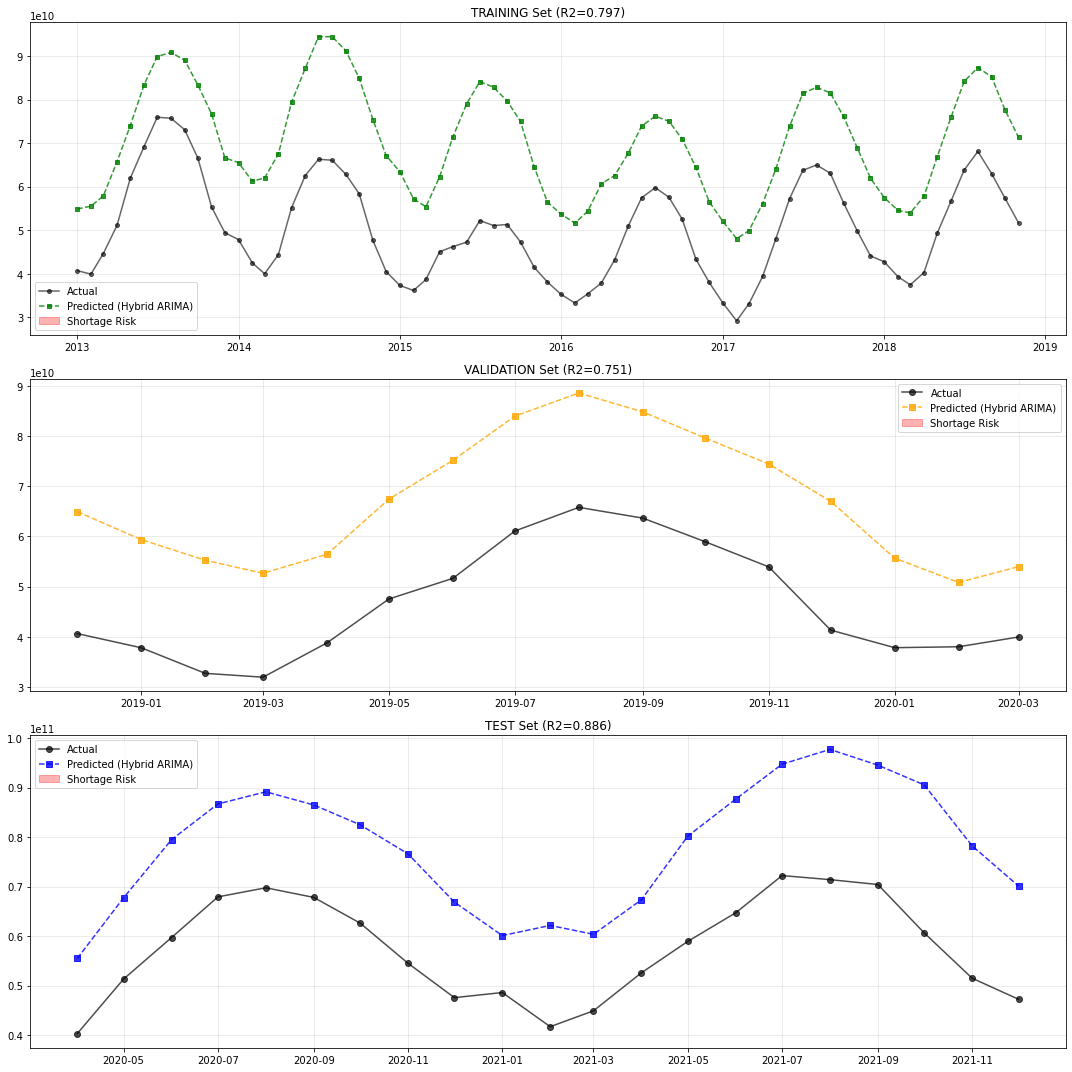


Generating Margin Efficiency Plot...


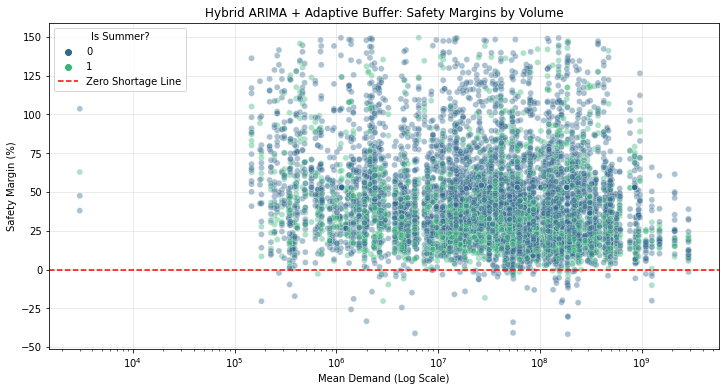


✅ PROCESS COMPLETE - HYBRID ARIMA


In [4]:
# =============================================================================
# HYBRID PIPELINE: ARIMA (Anchor) + LIGHTGBM (Residuals) + ADAPTIVE BUFFER
# Goal: Combine Time-Series Statistical Power with ML flexibility
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings
import os

warnings.filterwarnings('ignore')
np.random.seed(42)

# === CONFIGURATION ===
FILE_PATH = "CaRDS.csv" 
TEST_SIZE = 0.2
VAL_SIZE = 0.15

print("="*70)
print("HYBRID MODEL: ARIMA ANCHOR + LIGHTGBM RESIDUALS + ADAPTIVE SAFETY")
print("="*70)

# =============================================================================
# 1. DATA LOADING & PROCESSING
# =============================================================================
def clean_physics_based(series):
    median_val = series.median()
    if pd.isna(median_val) or median_val <= 0:
        return series.fillna(0)
    phys_min = median_val * 0.05
    phys_max = median_val * 10.0
    mask_invalid = (series < phys_min) | (series > phys_max)
    if mask_invalid.any():
        series_clean = series.copy()
        series_clean[mask_invalid] = np.nan
        series_clean = series_clean.interpolate(method='linear', limit_direction='both')
        return series_clean
    return series

def load_and_process_data(file_path):
    print(f"\n📂 Loading data from {file_path}...")
    if not os.path.exists(file_path):
        print(f"❌ Error: File '{file_path}' not found.")
        return None
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return None

    df['Variable'] = df['Variable'].astype(str).str.strip().str.lower()
    date_cols = [c for c in df.columns if c not in ['PWSID', 'Variable']]
    df_melt = df.melt(id_vars=['PWSID', 'Variable'], value_vars=date_cols,
                      var_name='Date', value_name='Value')
    df_pivot = df_melt.pivot_table(index=['PWSID', 'Date'],
                                   columns='Variable', values='Value').reset_index()
    
    rename_map = {'demand': 'Demand', 'temperature': 'Temperature',
                  'precipitation': 'Precipitation', 'pdsi': 'PDSI'}
    df_pivot.rename(columns=rename_map, inplace=True)
    df_pivot['Date'] = pd.to_datetime(df_pivot['Date'])
    df_final = df_pivot.sort_values(['PWSID', 'Date']).reset_index(drop=True)
    
    for col in ['Temperature', 'Precipitation', 'PDSI']:
        if col in df_final.columns:
            val = 0 if col == 'Precipitation' else df_final[col].median()
            df_final[col] = df_final[col].fillna(val)
    
    if 'Demand' in df_final.columns:
        print("   🔧 Applying Physics Envelope...")
        df_final['Demand'] = df_final.groupby('PWSID')['Demand'].transform(clean_physics_based)
        df_final['Demand'] = df_final['Demand'].fillna(0)
    
    return df_final

# =============================================================================
# 2. FEATURE ENGINEERING (For the Residual Model)
# =============================================================================
def create_features(df):
    print("\n🔨 Creating optimized features for Residual Model...")
    df = df.copy()
    
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Is_Summer_Peak'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)
    
    if 'Temperature' in df.columns:
        df['Temp_mean_3m'] = df.groupby('PWSID')['Temperature'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df['CDD'] = np.maximum(df['Temperature'] - 18, 0)
    
    # Lag features
    df['lag_1'] = df.groupby('PWSID')['Demand'].shift(1)
    df['lag_12'] = df.groupby('PWSID')['Demand'].shift(12)
    df['rolling_mean_12'] = df.groupby('PWSID')['Demand'].transform(
        lambda x: x.rolling(window=12, min_periods=1).mean()
    )
    df['diff_12'] = df.groupby('PWSID')['Demand'].diff(12)
    
    if 'Temperature' in df.columns:
        df['Temp_lag_1'] = df.groupby('PWSID')['Temperature'].shift(1)
        df['Summer_Heat_Interaction'] = df['Is_Summer_Peak'] * df['CDD']
    
    if 'Precipitation' in df.columns:
        df['Precip_lag_1'] = df.groupby('PWSID')['Precipitation'].shift(1)
    
    df = df.fillna(method='bfill').fillna(0)
    return df

df = load_and_process_data(FILE_PATH)
if df is None: exit()
df_features = create_features(df)

# =============================================================================
# 3. SPLIT DATA
# =============================================================================
unique_dates = df_features['Date'].sort_values().unique()
n_test = int(len(unique_dates) * TEST_SIZE)
n_val = int(len(unique_dates) * VAL_SIZE)

test_start = unique_dates[-n_test]
val_start = unique_dates[-(n_test + n_val)]

train_df = df_features[df_features['Date'] < val_start].copy()
val_df = df_features[(df_features['Date'] >= val_start) & (df_features['Date'] < test_start)].copy()
test_df = df_features[df_features['Date'] >= test_start].copy()

le = LabelEncoder()
train_df['PWSID_enc'] = le.fit_transform(train_df['PWSID'])
common_pwsids = set(train_df['PWSID']) & set(val_df['PWSID']) & set(test_df['PWSID'])
train_df = train_df[train_df['PWSID'].isin(common_pwsids)]
val_df = val_df[val_df['PWSID'].isin(common_pwsids)]
test_df = test_df[test_df['PWSID'].isin(common_pwsids)]

val_df['PWSID_enc'] = le.transform(val_df['PWSID'])
test_df['PWSID_enc'] = le.transform(test_df['PWSID'])

print(f"   Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# =============================================================================
# 4. STEP 1: ARIMA ANCHOR (PER STATION LOOP)
# =============================================================================
print("\n" + "="*70)
print("STEP 1: TRAINING ARIMA ANCHOR (Per PWSID)")
print("   ⚠️  Warning: This process is slower than Pure ML.")
print("="*70)

def fit_predict_arima_anchor(train_df, val_df, test_df):
    train_preds_map = {}
    val_preds_map = {}
    test_preds_map = {}
    
    unique_pwsids = train_df['PWSID_enc'].unique()
    
    # Loop qua từng trạm
    for pid in tqdm(unique_pwsids, desc="Fitting ARIMA Models"):
        # Lấy dữ liệu trạm đó
        tr_data = train_df[train_df['PWSID_enc'] == pid].set_index('Date')['Demand']
        val_data = val_df[val_df['PWSID_enc'] == pid].set_index('Date')['Demand']
        test_data = test_df[test_df['PWSID_enc'] == pid].set_index('Date')['Demand']
        
        # Đảm bảo tần suất ngày (Daily frequency)
        tr_data = tr_data.asfreq('D').fillna(method='ffill')
        
        try:
            # ARIMA(2,1,2) là cấu hình khá ổn định cho daily data
            # Nếu chạy quá lâu có thể giảm xuống (1,1,1)
            model = ARIMA(tr_data, order=(2, 1, 2), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            
            # Dự báo (In-sample & Out-of-sample)
            # Lưu ý: ARIMA predict theo index
            train_preds_map[pid] = model_fit.fittedvalues
            
            # Forecast cho Val & Test
            # Cách đơn giản nhất: Refit hoặc dùng forecast steps. 
            # Để nhanh và liên tục, ta dùng apply() lên data mới (One-step ahead forecast)
            val_preds_map[pid] = model_fit.apply(val_data).fittedvalues
            test_preds_map[pid] = model_fit.apply(test_data).fittedvalues
            
        except Exception as e:
            # Fallback: Nếu ARIMA lỗi (thường do data ngắn/hỏng), dùng Mean
            mean_val = tr_data.mean()
            train_preds_map[pid] = pd.Series([mean_val]*len(tr_data), index=tr_data.index)
            val_preds_map[pid] = pd.Series([mean_val]*len(val_data), index=val_data.index)
            test_preds_map[pid] = pd.Series([mean_val]*len(test_data), index=test_data.index)

    # Helper để map lại vào DataFrame chính
    def map_preds(df_target, preds_map):
        preds = []
        for idx, row in df_target.iterrows():
            pid = row['PWSID_enc']
            date = row['Date']
            try:
                val = preds_map[pid].loc[date]
            except:
                val = 0 # Fallback an toàn
            preds.append(val)
        return np.array(preds)

    # Cách map nhanh hơn dùng merge
    def dict_to_df(preds_map):
        df_list = []
        for pid, series in preds_map.items():
            tmp = series.reset_index()
            tmp.columns = ['Date', 'Pred']
            tmp['PWSID_enc'] = pid
            df_list.append(tmp)
        return pd.concat(df_list)

    print("   Mapping ARIMA predictions back to dataframe...")
    df_tr = dict_to_df(train_preds_map)
    df_val = dict_to_df(val_preds_map)
    df_te = dict_to_df(test_preds_map)
    
    # Merge lại vào khung chính
    anchor_train = train_df[['PWSID_enc', 'Date']].merge(df_tr, on=['PWSID_enc', 'Date'], how='left')['Pred'].fillna(0).values
    anchor_val = val_df[['PWSID_enc', 'Date']].merge(df_val, on=['PWSID_enc', 'Date'], how='left')['Pred'].fillna(0).values
    anchor_test = test_df[['PWSID_enc', 'Date']].merge(df_te, on=['PWSID_enc', 'Date'], how='left')['Pred'].fillna(0).values
    
    return anchor_train, anchor_val, anchor_test

# Chạy Anchor
anchor_train_pred, anchor_val_pred, anchor_test_pred = fit_predict_arima_anchor(train_df, val_df, test_df)
print(f"📈 Anchor (ARIMA) Val R²: {r2_score(val_df['Demand'], anchor_val_pred):.4f}")

# =============================================================================
# 5. STEP 2: RESIDUAL LEARNING (LIGHTGBM)
# =============================================================================
print("\n" + "="*70)
print("STEP 2: TRAINING RESIDUAL MODEL (LightGBM)")
print("="*70)

# Tính Residuals (Lỗi của ARIMA)
y_train = train_df['Demand'].values
y_val = val_df['Demand'].values
y_test = test_df['Demand'].values

train_residuals = y_train - anchor_train_pred
val_residuals = y_val - anchor_val_pred

# Features for ML
features_ml = ['PWSID_enc', 'Month', 'Year', 'Is_Summer_Peak',
            'lag_1', 'diff_12', 'rolling_mean_12',
            'Temp_lag_1', 'CDD', 'Summer_Heat_Interaction', 'Precip_lag_1']
features_ml = [c for c in features_ml if c in train_df.columns]

X_train_ml = train_df[features_ml]
X_val_ml = val_df[features_ml]
X_test_ml = test_df[features_ml]

# Sample Weights
sample_weight_train = np.ones(len(X_train_ml))
months_train = train_df['Month'].values
mask_summer = (months_train >= 6) & (months_train <= 8)
sample_weight_train[mask_summer] *= 1.3
# Tăng trọng số cho những điểm ARIMA dự báo thiếu (Under-pred)
mask_under = train_residuals > 0 
sample_weight_train[mask_under] *= 1.2

# LightGBM Params (Median Regression to fix ARIMA Bias)
lgb_params = {
    'objective': 'quantile',      
    'alpha': 0.5,                 # Median correction
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': 7,
    'n_estimators': 3000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

model_lgb = lgb.LGBMRegressor(**lgb_params)

print("   ⏳ Training LightGBM on Residuals...")
callbacks = [lgb.early_stopping(stopping_rounds=200, verbose=False)]

model_lgb.fit(
    X_train_ml, train_residuals,
    sample_weight=sample_weight_train,
    eval_set=[(X_val_ml, val_residuals)],
    eval_metric='quantile',
    callbacks=callbacks
)

# Predict Residuals
pred_res_train = model_lgb.predict(X_train_ml)
pred_res_val = model_lgb.predict(X_val_ml)
pred_res_test = model_lgb.predict(X_test_ml)

# Combine: Hybrid Prediction
raw_pred_train = anchor_train_pred + pred_res_train
raw_pred_val = anchor_val_pred + pred_res_val
raw_pred_test = anchor_test_pred + pred_res_test

# =============================================================================
# 6. POST-PROCESSING: SMART FLOOR
# =============================================================================
print("\n" + "="*70)
print("STEP 3: SMART FLOOR")
print("="*70)

def apply_smart_floor(base_pred, df_original):
    lag_12 = df_original['lag_12'].values
    lag_1 = df_original['lag_1'].values
    months = df_original['Month'].values
    
    floor_yoy = lag_12 * 1.02
    floor_mom = lag_1 * 0.92
    summer_mask = (months >= 6) & (months <= 8)
    floor_mom[summer_mask] = lag_1[summer_mask] * 0.95
    
    safe_pred = np.maximum.reduce([base_pred, floor_yoy, floor_mom])
    return safe_pred

floored_pred_train = apply_smart_floor(raw_pred_train, train_df)
floored_pred_val = apply_smart_floor(raw_pred_val, val_df)
floored_pred_test = apply_smart_floor(raw_pred_test, test_df)

# =============================================================================
# 7. POST-PROCESSING: ADAPTIVE PERSONALIZED BUFFER
# =============================================================================
print("\n" + "="*70)
print("STEP 4: ADAPTIVE BUFFER (Personalized Risk Profiling)")
print("="*70)

def generate_risk_profile(df_val, y_true_val, y_pred_raw):
    analysis = df_val[['PWSID_enc', 'Month']].copy()
    analysis['Actual'] = y_true_val
    analysis['Pred'] = y_pred_raw
    analysis['Shortage'] = analysis['Actual'] - analysis['Pred'] 
    
    risk_profile = analysis.groupby('PWSID_enc')['Shortage'].std().reset_index()
    risk_profile.rename(columns={'Shortage': 'Error_Std'}, inplace=True)
    
    shortage_only = analysis[analysis['Shortage'] > 0]
    if not shortage_only.empty:
        max_risk = shortage_only.groupby('PWSID_enc')['Shortage'].max().reset_index()
        max_risk.rename(columns={'Shortage': 'Max_Shortage'}, inplace=True)
    else:
        max_risk = pd.DataFrame(columns=['PWSID_enc', 'Max_Shortage'])
        
    summer_analysis = analysis[(analysis['Month'] >= 6) & (analysis['Month'] <= 8)]
    summer_shortage = summer_analysis[summer_analysis['Shortage'] > 0]
    if not summer_shortage.empty:
        max_summer_risk = summer_shortage.groupby('PWSID_enc')['Shortage'].max().reset_index()
        max_summer_risk.rename(columns={'Shortage': 'Max_Summer_Shortage'}, inplace=True)
    else:
        max_summer_risk = pd.DataFrame(columns=['PWSID_enc', 'Max_Summer_Shortage'])

    profile = risk_profile.merge(max_risk, on='PWSID_enc', how='left')
    profile = profile.merge(max_summer_risk, on='PWSID_enc', how='left')
    profile = profile.fillna(0)
    
    risk_map = profile.set_index('PWSID_enc').to_dict('index')
    return risk_map

def apply_adaptive_buffer(pred, df, risk_map):
    pwsid_encs = df['PWSID_enc'].values
    months = df['Month'].values
    
    buffers = []
    
    for i, pid in enumerate(pwsid_encs):
        profile = risk_map.get(pid, {'Error_Std': 0, 'Max_Shortage': 0, 'Max_Summer_Shortage': 0})
        
        base_buffer = 2.0 * profile['Error_Std']
        hist_buffer = profile['Max_Shortage'] * 1.05
        
        summer_buffer = 0
        if 6 <= months[i] <= 8:
            summer_buffer = profile['Max_Summer_Shortage'] * 1.15
            
        final_buffer = max(base_buffer, hist_buffer, summer_buffer)
        
        if pred[i] > 0:
            cap_limit = pred[i] * 0.5
            if final_buffer > cap_limit and final_buffer > profile['Max_Shortage'] * 1.1:
                 final_buffer = cap_limit
                 
        buffers.append(final_buffer)
        
    return pred + np.array(buffers)

print("   📊 Learning Risk Profiles from Validation History...")
risk_map = generate_risk_profile(val_df, y_val, floored_pred_val)

print("   🚀 Applying Adaptive Personalized Buffer...")
final_pred_train = apply_adaptive_buffer(floored_pred_train, train_df, risk_map)
final_pred_val = apply_adaptive_buffer(floored_pred_val, val_df, risk_map)
final_pred_test = apply_adaptive_buffer(floored_pred_test, test_df, risk_map)

# =============================================================================
# 8. FINAL EVALUATION & VISUALIZATION
# =============================================================================
print("\n" + "="*70)
print("FINAL EVALUATION")
print("="*70)

def evaluate_model(y_true, y_pred, df_original, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    under_pred_count = np.sum(y_pred < y_true)
    under_rate = (under_pred_count / len(y_true)) * 100
    over_rate = 100 - under_rate
    
    avg_shortage = np.mean(np.maximum(y_true - y_pred, 0))
    avg_surplus = np.mean(np.maximum(y_pred - y_true, 0))
    
    months = df_original['Month'].values
    summer_mask = (months >= 6) & (months <= 8)
    summer_under = 0.0
    if np.sum(summer_mask) > 0:
        summer_under = np.sum((y_pred[summer_mask] < y_true[summer_mask])) / np.sum(summer_mask) * 100
    
    print(f"\n📊 {dataset_name}:")
    print(f"   MAE: {mae:,.2f} | R²: {r2:.4f}")
    print(f"   ⚠️  Under-pred: {under_rate:.2f}% | Avg Shortage: {avg_shortage:,.2f}")
    print(f"   ✅ Over-pred: {over_rate:.2f}% | Avg Surplus: {avg_surplus:,.2f}")
    print(f"   🌞 Summer Under-pred: {summer_under:.2f}% (CRITICAL METRIC)")
    
    return {'R2': r2}

train_metrics = evaluate_model(y_train, final_pred_train, train_df, "TRAINING SET")
val_metrics = evaluate_model(y_val, final_pred_val, val_df, "VALIDATION SET")
test_metrics = evaluate_model(y_test, final_pred_test, test_df, "TEST SET")

# --- PLOTTING SECTION ---
print("\n" + "="*60)
print("VISUALIZING RESULTS")
print("="*60)

# Calculate mean_map for plotting
profile_df = pd.concat([train_df, val_df])
mean_map = profile_df.groupby('PWSID_enc')['Demand'].mean().to_dict()

# Prepare Data for Plotting
def prepare_plot_data(df, y_true, y_pred):
    plot_df = df.copy()
    plot_df['Actual'] = y_true
    plot_df['Predicted'] = y_pred
    return plot_df.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()

train_monthly = prepare_plot_data(train_df, y_train, final_pred_train)
val_monthly = prepare_plot_data(val_df, y_val, final_pred_val)
test_monthly = prepare_plot_data(test_df, y_test, final_pred_test)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Plot Train
axes[0].plot(train_monthly['Date'], train_monthly['Actual'], 'k-o', label='Actual', alpha=0.6, markersize=4)
axes[0].plot(train_monthly['Date'], train_monthly['Predicted'], 'g--s', label='Predicted (Hybrid ARIMA)', alpha=0.8, markersize=4)
axes[0].fill_between(train_monthly['Date'], train_monthly['Predicted'], train_monthly['Actual'],
                     where=(train_monthly['Predicted'] < train_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[0].set_title(f"TRAINING Set (R2={train_metrics['R2']:.3f})")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Validation
axes[1].plot(val_monthly['Date'], val_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[1].plot(val_monthly['Date'], val_monthly['Predicted'], 'orange', linestyle='--', marker='s', label='Predicted (Hybrid ARIMA)', alpha=0.8)
axes[1].fill_between(val_monthly['Date'], val_monthly['Predicted'], val_monthly['Actual'],
                     where=(val_monthly['Predicted'] < val_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[1].set_title(f"VALIDATION Set (R2={val_metrics['R2']:.3f})")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot Test
axes[2].plot(test_monthly['Date'], test_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[2].plot(test_monthly['Date'], test_monthly['Predicted'], 'b--s', label='Predicted (Hybrid ARIMA)', alpha=0.8)
axes[2].fill_between(test_monthly['Date'], test_monthly['Predicted'], test_monthly['Actual'],
                     where=(test_monthly['Predicted'] < test_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[2].set_title(f"TEST Set (R2={test_metrics['R2']:.3f})")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Margin Efficiency Plot
print("\nGenerating Margin Efficiency Plot...")
test_analysis = test_df.copy()
test_analysis['Demand'] = y_test
test_analysis['Pred'] = final_pred_test
test_analysis['Margin_Pct'] = ((test_analysis['Pred'] - test_analysis['Demand']) / (test_analysis['Demand']+1)) * 100
test_analysis['Mean_Volume'] = test_analysis['PWSID_enc'].map(mean_map)

plt.figure(figsize=(12, 6))
plot_data = test_analysis[(test_analysis['Margin_Pct'] > -50) & (test_analysis['Margin_Pct'] < 150)]

sns.scatterplot(data=plot_data, x='Mean_Volume', y='Margin_Pct', hue='Is_Summer_Peak', alpha=0.4, palette='viridis')
plt.xscale('log')
plt.axhline(0, color='red', linestyle='--', label='Zero Shortage Line')
plt.title('Hybrid ARIMA + Adaptive Buffer: Safety Margins by Volume')
plt.xlabel('Mean Demand (Log Scale)')
plt.ylabel('Safety Margin (%)')
plt.legend(title='Is Summer?')
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ PROCESS COMPLETE - HYBRID ARIMA")

HYBRID MODEL: ARIMA ANCHOR + XGBOOST RESIDUALS + ADAPTIVE SAFETY

📂 Loading data from CaRDS.csv...
   🔧 Applying Physics Envelope...

🔨 Creating optimized features for Residual Model...
   Train: 28684 | Val: 6464 | Test: 8484

STEP 1: TRAINING ARIMA ANCHOR (Per PWSID)
   ⚠️  Warning: This process involves fitting many small ARIMA models.


Fitting ARIMA Models: 100%|██████████| 404/404 [00:16<00:00, 24.92it/s]


   Mapping ARIMA predictions back to dataframe...
📈 Anchor (ARIMA) Val R²: 0.8971

STEP 2: TRAINING RESIDUAL MODEL (XGBoost)
   ⏳ Training XGBoost on Residuals...
[0]	validation_0-quantile:12862293.40087
[500]	validation_0-quantile:11159985.99028
[1000]	validation_0-quantile:10765665.25570
[1500]	validation_0-quantile:10532477.55144
[2000]	validation_0-quantile:10385637.23467
[2500]	validation_0-quantile:10294181.69458
[2999]	validation_0-quantile:10222972.38403

STEP 3: SMART FLOOR

STEP 4: ADAPTIVE BUFFER (Personalized Risk Profiling)
   📊 Learning Risk Profiles from Validation History...
   🚀 Applying Adaptive Personalized Buffer...

FINAL EVALUATION (ARIMA + XGBOOST)

📊 TRAINING SET:
   MAE: 50,050,964.43 | R²: 0.7960
   ⚠️  Under-pred: 0.89% | Avg Shortage: 161,007.28
   ✅ Over-pred: 99.11% | Avg Surplus: 49,889,957.16
   🌞 Summer Under-pred: 0.98%

📊 VALIDATION SET:
   MAE: 51,008,525.97 | R²: 0.7482
   ⚠️  Under-pred: 0.09% | Avg Shortage: 2,692.45
   ✅ Over-pred: 99.91% | Avg S

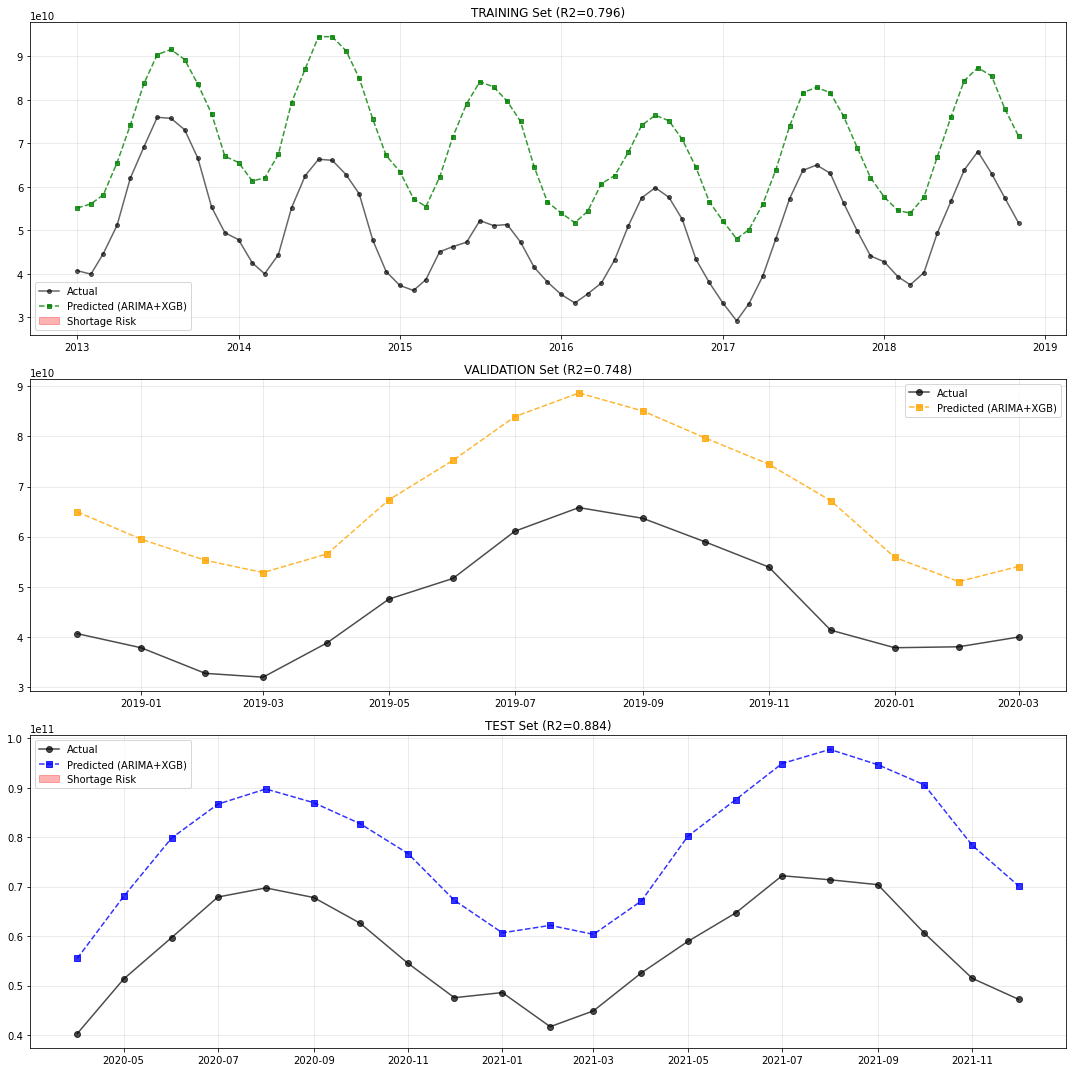


✅ PROCESS COMPLETE - HYBRID ARIMA + XGBOOST


In [3]:
# =============================================================================
# HYBRID PIPELINE V2: ARIMA (Anchor) + XGBOOST (Residuals) + ADAPTIVE BUFFER
# Goal: Combine Time-Series Statistical Power with XGBoost Gradient Boosting
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb  # <--- CHANGED FROM LIGHTGBM TO XGBOOST
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings
import os

warnings.filterwarnings('ignore')
np.random.seed(42)

# === CONFIGURATION ===
FILE_PATH = "CaRDS.csv" 
TEST_SIZE = 0.2
VAL_SIZE = 0.15

print("="*70)
print("HYBRID MODEL: ARIMA ANCHOR + XGBOOST RESIDUALS + ADAPTIVE SAFETY")
print("="*70)

# =============================================================================
# 1. DATA LOADING & PROCESSING
# =============================================================================
def clean_physics_based(series):
    median_val = series.median()
    if pd.isna(median_val) or median_val <= 0:
        return series.fillna(0)
    phys_min = median_val * 0.05
    phys_max = median_val * 10.0
    mask_invalid = (series < phys_min) | (series > phys_max)
    if mask_invalid.any():
        series_clean = series.copy()
        series_clean[mask_invalid] = np.nan
        series_clean = series_clean.interpolate(method='linear', limit_direction='both')
        return series_clean
    return series

def load_and_process_data(file_path):
    print(f"\n📂 Loading data from {file_path}...")
    if not os.path.exists(file_path):
        print(f"❌ Error: File '{file_path}' not found.")
        return None
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return None

    df['Variable'] = df['Variable'].astype(str).str.strip().str.lower()
    date_cols = [c for c in df.columns if c not in ['PWSID', 'Variable']]
    df_melt = df.melt(id_vars=['PWSID', 'Variable'], value_vars=date_cols,
                      var_name='Date', value_name='Value')
    df_pivot = df_melt.pivot_table(index=['PWSID', 'Date'],
                                   columns='Variable', values='Value').reset_index()
    
    rename_map = {'demand': 'Demand', 'temperature': 'Temperature',
                  'precipitation': 'Precipitation', 'pdsi': 'PDSI'}
    df_pivot.rename(columns=rename_map, inplace=True)
    df_pivot['Date'] = pd.to_datetime(df_pivot['Date'])
    df_final = df_pivot.sort_values(['PWSID', 'Date']).reset_index(drop=True)
    
    for col in ['Temperature', 'Precipitation', 'PDSI']:
        if col in df_final.columns:
            val = 0 if col == 'Precipitation' else df_final[col].median()
            df_final[col] = df_final[col].fillna(val)
    
    if 'Demand' in df_final.columns:
        print("   🔧 Applying Physics Envelope...")
        df_final['Demand'] = df_final.groupby('PWSID')['Demand'].transform(clean_physics_based)
        df_final['Demand'] = df_final['Demand'].fillna(0)
    
    return df_final

# =============================================================================
# 2. FEATURE ENGINEERING
# =============================================================================
def create_features(df):
    print("\n🔨 Creating optimized features for Residual Model...")
    df = df.copy()
    
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Is_Summer_Peak'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)
    
    if 'Temperature' in df.columns:
        df['Temp_mean_3m'] = df.groupby('PWSID')['Temperature'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df['CDD'] = np.maximum(df['Temperature'] - 18, 0)
    
    # Lag features
    df['lag_1'] = df.groupby('PWSID')['Demand'].shift(1)
    df['lag_12'] = df.groupby('PWSID')['Demand'].shift(12)
    df['rolling_mean_12'] = df.groupby('PWSID')['Demand'].transform(
        lambda x: x.rolling(window=12, min_periods=1).mean()
    )
    df['diff_12'] = df.groupby('PWSID')['Demand'].diff(12)
    
    if 'Temperature' in df.columns:
        df['Temp_lag_1'] = df.groupby('PWSID')['Temperature'].shift(1)
        df['Summer_Heat_Interaction'] = df['Is_Summer_Peak'] * df['CDD']
    
    if 'Precipitation' in df.columns:
        df['Precip_lag_1'] = df.groupby('PWSID')['Precipitation'].shift(1)
    
    df = df.fillna(method='bfill').fillna(0)
    return df

df = load_and_process_data(FILE_PATH)
if df is None: exit()
df_features = create_features(df)

# =============================================================================
# 3. SPLIT DATA
# =============================================================================
unique_dates = df_features['Date'].sort_values().unique()
n_test = int(len(unique_dates) * TEST_SIZE)
n_val = int(len(unique_dates) * VAL_SIZE)

test_start = unique_dates[-n_test]
val_start = unique_dates[-(n_test + n_val)]

train_df = df_features[df_features['Date'] < val_start].copy()
val_df = df_features[(df_features['Date'] >= val_start) & (df_features['Date'] < test_start)].copy()
test_df = df_features[df_features['Date'] >= test_start].copy()

le = LabelEncoder()
train_df['PWSID_enc'] = le.fit_transform(train_df['PWSID'])
common_pwsids = set(train_df['PWSID']) & set(val_df['PWSID']) & set(test_df['PWSID'])
train_df = train_df[train_df['PWSID'].isin(common_pwsids)]
val_df = val_df[val_df['PWSID'].isin(common_pwsids)]
test_df = test_df[test_df['PWSID'].isin(common_pwsids)]

val_df['PWSID_enc'] = le.transform(val_df['PWSID'])
test_df['PWSID_enc'] = le.transform(test_df['PWSID'])

print(f"   Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# =============================================================================
# 4. STEP 1: ARIMA ANCHOR (PER STATION LOOP)
# =============================================================================
print("\n" + "="*70)
print("STEP 1: TRAINING ARIMA ANCHOR (Per PWSID)")
print("   ⚠️  Warning: This process involves fitting many small ARIMA models.")
print("="*70)

def fit_predict_arima_anchor(train_df, val_df, test_df):
    train_preds_map = {}
    val_preds_map = {}
    test_preds_map = {}
    
    unique_pwsids = train_df['PWSID_enc'].unique()
    
    # Loop qua từng trạm
    for pid in tqdm(unique_pwsids, desc="Fitting ARIMA Models"):
        # Lấy dữ liệu trạm đó
        tr_data = train_df[train_df['PWSID_enc'] == pid].set_index('Date')['Demand']
        val_data = val_df[val_df['PWSID_enc'] == pid].set_index('Date')['Demand']
        test_data = test_df[test_df['PWSID_enc'] == pid].set_index('Date')['Demand']
        
        # Đảm bảo tần suất
        tr_data = tr_data.asfreq('D').fillna(method='ffill')
        
        try:
            # ARIMA(2,1,2) configuration
            model = ARIMA(tr_data, order=(2, 1, 2), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            
            # Dự báo (In-sample & Out-of-sample)
            train_preds_map[pid] = model_fit.fittedvalues
            
            # Forecast cho Val & Test dùng apply (nhanh hơn refit)
            val_preds_map[pid] = model_fit.apply(val_data).fittedvalues
            test_preds_map[pid] = model_fit.apply(test_data).fittedvalues
            
        except Exception as e:
            # Fallback
            mean_val = tr_data.mean()
            train_preds_map[pid] = pd.Series([mean_val]*len(tr_data), index=tr_data.index)
            val_preds_map[pid] = pd.Series([mean_val]*len(val_data), index=val_data.index)
            test_preds_map[pid] = pd.Series([mean_val]*len(test_data), index=test_data.index)

    def dict_to_df(preds_map):
        df_list = []
        for pid, series in preds_map.items():
            tmp = series.reset_index()
            tmp.columns = ['Date', 'Pred']
            tmp['PWSID_enc'] = pid
            df_list.append(tmp)
        return pd.concat(df_list)

    print("   Mapping ARIMA predictions back to dataframe...")
    df_tr = dict_to_df(train_preds_map)
    df_val = dict_to_df(val_preds_map)
    df_te = dict_to_df(test_preds_map)
    
    # Merge lại vào khung chính
    anchor_train = train_df[['PWSID_enc', 'Date']].merge(df_tr, on=['PWSID_enc', 'Date'], how='left')['Pred'].fillna(0).values
    anchor_val = val_df[['PWSID_enc', 'Date']].merge(df_val, on=['PWSID_enc', 'Date'], how='left')['Pred'].fillna(0).values
    anchor_test = test_df[['PWSID_enc', 'Date']].merge(df_te, on=['PWSID_enc', 'Date'], how='left')['Pred'].fillna(0).values
    
    return anchor_train, anchor_val, anchor_test

# Chạy Anchor
anchor_train_pred, anchor_val_pred, anchor_test_pred = fit_predict_arima_anchor(train_df, val_df, test_df)
print(f"📈 Anchor (ARIMA) Val R²: {r2_score(val_df['Demand'], anchor_val_pred):.4f}")

# =============================================================================
# 5. STEP 2: RESIDUAL LEARNING (XGBOOST)
# =============================================================================
print("\n" + "="*70)
print("STEP 2: TRAINING RESIDUAL MODEL (XGBoost)")
print("="*70)

# Tính Residuals (Lỗi của ARIMA)
y_train = train_df['Demand'].values
y_val = val_df['Demand'].values
y_test = test_df['Demand'].values

train_residuals = y_train - anchor_train_pred
val_residuals = y_val - anchor_val_pred

# Features for ML
features_ml = ['PWSID_enc', 'Month', 'Year', 'Is_Summer_Peak',
            'lag_1', 'diff_12', 'rolling_mean_12',
            'Temp_lag_1', 'CDD', 'Summer_Heat_Interaction', 'Precip_lag_1']
features_ml = [c for c in features_ml if c in train_df.columns]

X_train_ml = train_df[features_ml]
X_val_ml = val_df[features_ml]
X_test_ml = test_df[features_ml]

# Sample Weights
sample_weight_train = np.ones(len(X_train_ml))
months_train = train_df['Month'].values
mask_summer = (months_train >= 6) & (months_train <= 8)
sample_weight_train[mask_summer] *= 1.3
mask_under = train_residuals > 0 
sample_weight_train[mask_under] *= 1.2

# --- XGBOOST CONFIGURATION ---
xgb_params = {
    # Objective: quantile error (giống Median regression, giảm tác động outlier)
    # Nếu version XGB cũ, có thể thay bằng 'reg:absoluteerror'
    'objective': 'reg:quantileerror', 
    'quantile_alpha': 0.5,
    'n_estimators': 3000,
    'learning_rate': 0.02,
    'max_depth': 6,          # Depth 6 tương đương num_leaves ~64
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'tree_method': 'hist',   # Tối ưu tốc độ cho data lớn
    'early_stopping_rounds': 200,
    'verbosity': 1
}

model_xgb = xgb.XGBRegressor(**xgb_params)

print("   ⏳ Training XGBoost on Residuals...")

# Lưu ý: XGBoost nhận eval_set để early stopping
model_xgb.fit(
    X_train_ml, train_residuals,
    sample_weight=sample_weight_train,
    eval_set=[(X_val_ml, val_residuals)],
    verbose=500
)

# Predict Residuals
pred_res_train = model_xgb.predict(X_train_ml)
pred_res_val = model_xgb.predict(X_val_ml)
pred_res_test = model_xgb.predict(X_test_ml)

# Combine: Hybrid Prediction
raw_pred_train = anchor_train_pred + pred_res_train
raw_pred_val = anchor_val_pred + pred_res_val
raw_pred_test = anchor_test_pred + pred_res_test

# =============================================================================
# 6. POST-PROCESSING: SMART FLOOR
# =============================================================================
print("\n" + "="*70)
print("STEP 3: SMART FLOOR")
print("="*70)

def apply_smart_floor(base_pred, df_original):
    lag_12 = df_original['lag_12'].values
    lag_1 = df_original['lag_1'].values
    months = df_original['Month'].values
    
    floor_yoy = lag_12 * 1.02
    floor_mom = lag_1 * 0.92
    summer_mask = (months >= 6) & (months <= 8)
    floor_mom[summer_mask] = lag_1[summer_mask] * 0.95
    
    safe_pred = np.maximum.reduce([base_pred, floor_yoy, floor_mom])
    return safe_pred

floored_pred_train = apply_smart_floor(raw_pred_train, train_df)
floored_pred_val = apply_smart_floor(raw_pred_val, val_df)
floored_pred_test = apply_smart_floor(raw_pred_test, test_df)

# =============================================================================
# 7. POST-PROCESSING: ADAPTIVE PERSONALIZED BUFFER
# =============================================================================
print("\n" + "="*70)
print("STEP 4: ADAPTIVE BUFFER (Personalized Risk Profiling)")
print("="*70)

def generate_risk_profile(df_val, y_true_val, y_pred_raw):
    analysis = df_val[['PWSID_enc', 'Month']].copy()
    analysis['Actual'] = y_true_val
    analysis['Pred'] = y_pred_raw
    analysis['Shortage'] = analysis['Actual'] - analysis['Pred'] 
    
    risk_profile = analysis.groupby('PWSID_enc')['Shortage'].std().reset_index()
    risk_profile.rename(columns={'Shortage': 'Error_Std'}, inplace=True)
    
    shortage_only = analysis[analysis['Shortage'] > 0]
    if not shortage_only.empty:
        max_risk = shortage_only.groupby('PWSID_enc')['Shortage'].max().reset_index()
        max_risk.rename(columns={'Shortage': 'Max_Shortage'}, inplace=True)
    else:
        max_risk = pd.DataFrame(columns=['PWSID_enc', 'Max_Shortage'])
        
    summer_analysis = analysis[(analysis['Month'] >= 6) & (analysis['Month'] <= 8)]
    summer_shortage = summer_analysis[summer_analysis['Shortage'] > 0]
    if not summer_shortage.empty:
        max_summer_risk = summer_shortage.groupby('PWSID_enc')['Shortage'].max().reset_index()
        max_summer_risk.rename(columns={'Shortage': 'Max_Summer_Shortage'}, inplace=True)
    else:
        max_summer_risk = pd.DataFrame(columns=['PWSID_enc', 'Max_Summer_Shortage'])

    profile = risk_profile.merge(max_risk, on='PWSID_enc', how='left')
    profile = profile.merge(max_summer_risk, on='PWSID_enc', how='left')
    profile = profile.fillna(0)
    
    risk_map = profile.set_index('PWSID_enc').to_dict('index')
    return risk_map

def apply_adaptive_buffer(pred, df, risk_map):
    pwsid_encs = df['PWSID_enc'].values
    months = df['Month'].values
    
    buffers = []
    
    for i, pid in enumerate(pwsid_encs):
        profile = risk_map.get(pid, {'Error_Std': 0, 'Max_Shortage': 0, 'Max_Summer_Shortage': 0})
        
        base_buffer = 2.0 * profile['Error_Std']
        hist_buffer = profile['Max_Shortage'] * 1.05
        
        summer_buffer = 0
        if 6 <= months[i] <= 8:
            summer_buffer = profile['Max_Summer_Shortage'] * 1.15
            
        final_buffer = max(base_buffer, hist_buffer, summer_buffer)
        
        if pred[i] > 0:
            cap_limit = pred[i] * 0.5
            if final_buffer > cap_limit and final_buffer > profile['Max_Shortage'] * 1.1:
                 final_buffer = cap_limit
                 
        buffers.append(final_buffer)
        
    return pred + np.array(buffers)

print("   📊 Learning Risk Profiles from Validation History...")
risk_map = generate_risk_profile(val_df, y_val, floored_pred_val)

print("   🚀 Applying Adaptive Personalized Buffer...")
final_pred_train = apply_adaptive_buffer(floored_pred_train, train_df, risk_map)
final_pred_val = apply_adaptive_buffer(floored_pred_val, val_df, risk_map)
final_pred_test = apply_adaptive_buffer(floored_pred_test, test_df, risk_map)

# =============================================================================
# 8. FINAL EVALUATION & VISUALIZATION
# =============================================================================
print("\n" + "="*70)
print("FINAL EVALUATION (ARIMA + XGBOOST)")
print("="*70)

def evaluate_model(y_true, y_pred, df_original, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    under_pred_count = np.sum(y_pred < y_true)
    under_rate = (under_pred_count / len(y_true)) * 100
    over_rate = 100 - under_rate
    
    avg_shortage = np.mean(np.maximum(y_true - y_pred, 0))
    avg_surplus = np.mean(np.maximum(y_pred - y_true, 0))
    
    months = df_original['Month'].values
    summer_mask = (months >= 6) & (months <= 8)
    summer_under = 0.0
    if np.sum(summer_mask) > 0:
        summer_under = np.sum((y_pred[summer_mask] < y_true[summer_mask])) / np.sum(summer_mask) * 100
    
    print(f"\n📊 {dataset_name}:")
    print(f"   MAE: {mae:,.2f} | R²: {r2:.4f}")
    print(f"   ⚠️  Under-pred: {under_rate:.2f}% | Avg Shortage: {avg_shortage:,.2f}")
    print(f"   ✅ Over-pred: {over_rate:.2f}% | Avg Surplus: {avg_surplus:,.2f}")
    print(f"   🌞 Summer Under-pred: {summer_under:.2f}%")
    
    return {'R2': r2}

train_metrics = evaluate_model(y_train, final_pred_train, train_df, "TRAINING SET")
val_metrics = evaluate_model(y_val, final_pred_val, val_df, "VALIDATION SET")
test_metrics = evaluate_model(y_test, final_pred_test, test_df, "TEST SET")

# --- PLOTTING ---
print("\n" + "="*60)
print("VISUALIZING RESULTS")
print("="*60)

profile_df = pd.concat([train_df, val_df])
mean_map = profile_df.groupby('PWSID_enc')['Demand'].mean().to_dict()

def prepare_plot_data(df, y_true, y_pred):
    plot_df = df.copy()
    plot_df['Actual'] = y_true
    plot_df['Predicted'] = y_pred
    return plot_df.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()

train_monthly = prepare_plot_data(train_df, y_train, final_pred_train)
val_monthly = prepare_plot_data(val_df, y_val, final_pred_val)
test_monthly = prepare_plot_data(test_df, y_test, final_pred_test)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Plot Train
axes[0].plot(train_monthly['Date'], train_monthly['Actual'], 'k-o', label='Actual', alpha=0.6, markersize=4)
axes[0].plot(train_monthly['Date'], train_monthly['Predicted'], 'g--s', label='Predicted (ARIMA+XGB)', alpha=0.8, markersize=4)
axes[0].fill_between(train_monthly['Date'], train_monthly['Predicted'], train_monthly['Actual'],
                     where=(train_monthly['Predicted'] < train_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[0].set_title(f"TRAINING Set (R2={train_metrics['R2']:.3f})")
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Plot Validation
axes[1].plot(val_monthly['Date'], val_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[1].plot(val_monthly['Date'], val_monthly['Predicted'], 'orange', linestyle='--', marker='s', label='Predicted (ARIMA+XGB)', alpha=0.8)
axes[1].set_title(f"VALIDATION Set (R2={val_metrics['R2']:.3f})")
axes[1].legend(); axes[1].grid(True, alpha=0.3)

# Plot Test
axes[2].plot(test_monthly['Date'], test_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[2].plot(test_monthly['Date'], test_monthly['Predicted'], 'b--s', label='Predicted (ARIMA+XGB)', alpha=0.8)
axes[2].fill_between(test_monthly['Date'], test_monthly['Predicted'], test_monthly['Actual'],
                     where=(test_monthly['Predicted'] < test_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[2].set_title(f"TEST Set (R2={test_metrics['R2']:.3f})")
axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ PROCESS COMPLETE - HYBRID ARIMA + XGBOOST")